# Central Differential Privacy (Server-Side Clipping)





**Central Differential Privacy (DP) with Server-Side Clipping** applies two steps:

1. **Clip client updates**
2. **Add noise to the aggregated model**

This approach ensures uniform clipping across clients and reduces communication overhead, but increases server-side computation.

For this, Flower provides DP wrappers around strategies like `FedAvg`. In our case, we use:

### CNN: `DifferentialPrivacyServerSideAdaptiveClipping`

This strategy **dynamically adjusts the clipping norm** during training based on the updates received. It helps balance privacy and utility more effectively than fixed clipping.

> We focus our experiments on this adaptive clipping approach.

---

In [1]:
%load_ext autoreload
%load_ext watermark
    
%autoreload 2
%watermark --python -p torch,flwr

Python implementation: CPython
Python version       : 3.12.10
IPython version      : 9.1.0

torch: 2.6.0
flwr : 1.18.0



--------

## Loading Dependencies

In [ ]:
import os
import sys
sys.path.append("../..")

import ray
import time

import torch.nn as nn
from torchvision.models import resnet18, ResNet18_Weights

from logging import ERROR

from flwr.common import ndarrays_to_parameters, Context 
from flwr.client import Client, ClientApp
from flwr.server import ServerApp, ServerConfig, ServerAppComponents
from flwr.server.strategy import DifferentialPrivacyServerSideAdaptiveClipping, FedAvg
from flwr.simulation import run_simulation

from src.config import ExperimentName
from src.paths import RAY_LOG_DIR
from src.FL_client import MedicalImageClient
from src.FL_server import weighted_average, build_evaluate_fn
from src.local_utility import load_yaml_config, set_device, prepare_FL_dataset, get_weights

from src.tracker import reset_base_memory_csv

In [ ]:
# Replace with appropritate values

data_name_ = 'alzheimer' #"skin_lesions" #
base_type_ = "CNN"           
exp_name_ = "CDP-SA"
num_labels_ = 4
experiment_name_ = ExperimentName.FL_CDP_SA_CNN

In [ ]:
DEVICE = set_device()
reset_base_memory_csv() 

fed_config = load_yaml_config(key="experiments", item_name=experiment_name_)
client_dataloaders = prepare_FL_dataset(exp_name= exp_name_, data_name=data_name_, base_type=base_type_, augment_data=True)

In [ ]:
def client_fn(context: Context) -> Client:
    """
    Creates and initializes a federated learning client.

    This function initializes a client in the federated learning setup by 
    assigning a unique partitioned dataset and a machine learning model 
    for training and validation.

    Args:
        context (Context): The execution context containing client-specific configurations.

    Returns:
        Client: A configured federated learning client ready to participate in training.
    """
    partition_id = int(context.node_config["partition-id"]) #<--- Get the client partition ID
    
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_labels_)

    # Assign partitioned client dataset
    train_loader, val_loader, test_loader = client_dataloaders[partition_id]
    
    return MedicalImageClient(model, train_loader, val_loader, exp_name=exp_name_, data_name = data_name_, base_type=base_type_, client_id=partition_id).to_client()

client = ClientApp(client_fn)

In [ ]:
def server_fn(context: Context):
    """
    Creates and configures the federated learning server using the FedAvg strategy.

    This function initializes the federated learning server with a FedAvg strategy,
    specifying the parameters for client participation in training and evaluation,
    the global model evaluation function, and the metric aggregation function.

    Args:
        context (Context): The execution context for the federated learning server.

    Returns:
        ServerAppComponents: A configured server application with the defined strategy
        and server settings.
    """
    model = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
    model.fc = nn.Linear(in_features=model.fc.in_features, out_features=num_labels_)
    params = ndarrays_to_parameters(get_weights(model))
    
    # Create FedAvg strategy
    strategy = FedAvg(
        fraction_fit=1.0,                 
        fraction_evaluate=1.0,            
        initial_parameters=params,        
        evaluate_fn=build_evaluate_fn(    #<--- Global evaluation function
            exp_name = exp_name_, 
            base_type = base_type_,
            data_name=data_name_, 
            experiment_item=experiment_name_, 
            num_labels=num_labels_
            ),        
        evaluate_metrics_aggregation_fn=weighted_average
    )
    
    # Wrap the strategy with the DifferentialPrivacyServerSideFixedClipping wrapper
    dp_strategy = DifferentialPrivacyServerSideAdaptiveClipping(
        strategy= strategy,
        noise_multiplier = 0.1,
        num_sampled_clients = fed_config.get("num_clients"),
        initial_clipping_norm = 0.1,
        target_clipped_quantile= 0.1,
        clip_norm_lr = 0.2,
        clipped_count_stddev= fed_config.get("num_clients")/20
        )
    
    # Configure the server with the specified number of federated rounds
    sever_config = ServerConfig(num_rounds=fed_config['num_rounds']) #<--- no. of federated rounds
    
    return ServerAppComponents(strategy = dp_strategy, config = sever_config)
server = ServerApp(server_fn = server_fn) 

In [9]:
backend_setup = {
    "init_args": {
        "logging_level": ERROR, 
        "log_to_driver": fed_config.get("log_to_driver")
    },
    "client_resources": {
        "num_cpus": fed_config.get("num_cpus"), 
        "num_gpus": fed_config.get("num_gpus")            
    },
}

# When running on GPU, assign an entire GPU for each client
if DEVICE == "cuda": 
    backend_setup["client_resources"] = {"num_cpus": 1, "num_gpus": 1.0}

--- 

## Initiate the Simulation 

Initiate the simulation by passing the server and client apps, and specify the number of supernodes that will be selected on every round. 

2025-05-04 23:01:41,000	INFO worker.py:1771 -- Started a local Ray instance.
2025-05-04 23:01:41,338	INFO packaging.py:530 -- Creating a file package for local directory '/home/emeka/PrivacyBench'.
2025-05-04 23:01:41,779	INFO packaging.py:358 -- Pushing file package 'gcs://_ray_pkg_d84ffdccdcff6f8c.zip' (16.85MiB) to Ray cluster...
2025-05-04 23:01:41,829	INFO packaging.py:371 -- Successfully pushed file package 'gcs://_ray_pkg_d84ffdccdcff6f8c.zip'.
INFO :      Starting Flower ServerApp, config: num_rounds=20, no round_timeout
INFO :      
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Starting evaluation of initial global parameters
[codecarbon WARNING @ 23:01:43] Multiple instances of codecarbon are allowed to run at the same time.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead t

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=49324) 


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:02:20,933 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 744161280; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:02:30,943 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 744165376; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: parameters are clipped by value: 0.1000.
INFO :      aggregate_fit: central DP noise with 0.0030 stdev added
(raylet) [2025-05-04 23:02:40,952 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 744177664; capacity: 52589998080. Object creation will fail if spilling is required.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (1, nan, {'accuracy': 0.134375}, 55.97205589399982)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds


(ClientAppActor pid=49324) Seed set to 42
(ClientAppActor pid=49324) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49324) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49324)   self.pid = os.fork()
(raylet) [2025-05-04 23:03:10,983 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 744058880; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:03:20,995 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 744030208; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 20 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.0842.
INFO :      aggregate_fit: parameters are clipped by value: 0.0842.
INFO :      aggregate_fit: parameters are clipped by value: 0.0842.
INFO :      aggregate_fit: central DP noise with 0.0025 stdev added
(raylet) [2025-05-04 23:03:31,006 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 744083456; capacity: 52589998080. Object creation will fail if spilling is required.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (2, nan, {'accuracy': 0.134375}, 106.02580726699989)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49324) /home/emeka/.loca

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49324) 


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:04:01,036 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743960576; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:04:11,045 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743952384; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: 

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 20 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.0709.
INFO :      aggregate_fit: parameters are clipped by value: 0.0709.
INFO :      aggregate_fit: central DP noise with 0.0021 stdev added
(raylet) [2025-05-04 23:04:21,055 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743989248; capacity: 52589998080. Object creation will fail if spilling is required.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (3, nan, {'accuracy': 0.134375}, 155.638731905)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multipr

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 22 seconds


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:04:51,082 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743616512; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:05:01,090 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743604224; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.0584.
INFO :      aggregate_fit: parameters are clipped by value: 0.0584.
INFO :      aggregate_fit: parameters are clipped by value: 0.0584.
INFO :      aggregate_fit: central DP noise with 0.0017 stdev added
(raylet) [2025-05-04 23:05:11,100 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743624704; capacity: 52589998080. Object creation will fail if spilling is required.
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (4, nan, {'accuracy': 0.134375}, 206.08568669299984)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.loca

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=49324) 


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:05:41,130 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743624704; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:05:51,140 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743469056; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:06:01,150 E 47422 47458] (raylet) file_system_monitor.cc:111: /h

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 22 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.0488.
INFO :      aggregate_fit: parameters are clipped by value: 0.0488.
INFO :      aggregate_fit: parameters are clipped by value: 0.0488.
INFO :      aggregate_fit: central DP noise with 0.0014 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (5, nan, {'accuracy': 0.134375}, 258.5556431629998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
INFO :      aggreg

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds


(raylet) [2025-05-04 23:06:31,180 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743452672; capacity: 52589998080. Object creation will fail if spilling is required.
(ClientAppActor pid=49324) Seed set to 42
(ClientAppActor pid=49324) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49324) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49324)   self.pid = os.fork()
(raylet) [2025-05-04 23:06:41,190 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743452672; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:06:51,199 E 47422 47458] (raylet) file_system_monitor.cc:111: /h

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 21 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.0404.
INFO :      aggregate_fit: parameters are clipped by value: 0.0404.
INFO :      aggregate_fit: central DP noise with 0.0012 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (6, nan, {'accuracy': 0.134375}, 308.85944224700006)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO :

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49324) 


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:07:31,252 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743337984; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:07:41,262 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743264256; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: 

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.0334.
INFO :      aggregate_fit: parameters are clipped by value: 0.0334.
INFO :      aggregate_fit: central DP noise with 0.0010 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (7, nan, {'accuracy': 0.134375}, 359.4111721190002)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO : 

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 21 seconds


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:08:21,303 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 742871040; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:08:31,313 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 742862848; capacity: 52589998080. Object creation will fail if spilling is required.


(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 20 seconds


INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0283.
INFO :      aggregate_fit: parameters are clipped by value: 0.0283.
INFO :      aggregate_fit: parameters are clipped by value: 0.0283.
INFO :      aggregate_fit: central DP noise with 0.0008 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (8, nan, {'accuracy': 0.134375}, 409.17836493799996)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(Clien

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49324) 


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:09:11,351 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743108608; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:09:21,360 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 743104512; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: 

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.0239.
INFO :      aggregate_fit: parameters are clipped by value: 0.0239.
INFO :      aggregate_fit: central DP noise with 0.0007 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (9, nan, {'accuracy': 0.134375}, 459.7270524370001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
INFO :      aggregate_evaluate: received 3 results and 0 failures
INFO :      
INFO : 

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()


(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 24 seconds


(raylet) [2025-05-04 23:10:01,401 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 742903808; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:10:11,412 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 742858752; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: parameters are clipped by value: 0.0199.


(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 24 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.0199.
INFO :      aggregate_fit: parameters are clipped by value: 0.0199.
INFO :      aggregate_fit: central DP noise with 0.0006 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 23:10:21,423 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 742821888; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      fit progress: (10, nan, {'accuracy': 0.134375}, 513.820604561)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multip

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=49324) 


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:10:51,452 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 742457344; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:11:01,463 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 742445056; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: 

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.0166.
INFO :      aggregate_fit: parameters are clipped by value: 0.0166.
INFO :      aggregate_fit: central DP noise with 0.0005 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 23:11:11,473 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 742367232; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      fit progress: (11, nan, {'accuracy': 0.134375}, 565.300774504)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multip

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 22 seconds


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:11:41,505 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 742207488; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:11:51,515 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 742039552; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: 

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 20 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: parameters are clipped by value: 0.0139.
INFO :      aggregate_fit: central DP noise with 0.0004 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 23:12:01,526 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 742010880; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      fit progress: (12, nan, {'accuracy': 0.134375}, 614.7831922609998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/mu

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49324) 


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:12:31,559 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 741904384; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:12:41,570 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 741847040; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: 

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.0115.
INFO :      aggregate_fit: parameters are clipped by value: 0.0115.
INFO :      aggregate_fit: central DP noise with 0.0003 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 23:12:51,579 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 741679104; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      fit progress: (13, nan, {'accuracy': 0.134375}, 664.9874040539999)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/mu

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 22 seconds


(ClientAppActor pid=49324) Seed set to 42
(ClientAppActor pid=49324) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49324) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49324)   self.pid = os.fork()
(raylet) [2025-05-04 23:13:21,610 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 741548032; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:13:31,621 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 741523456; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: 

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 20 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.0097.
INFO :      aggregate_fit: parameters are clipped by value: 0.0097.
INFO :      aggregate_fit: central DP noise with 0.0003 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 23:13:41,631 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 741400576; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      fit progress: (14, nan, {'accuracy': 0.134375}, 714.9815233599998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/mu

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49325) 


(ClientAppActor pid=49324) Seed set to 42
(ClientAppActor pid=49324) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49324) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49324)   self.pid = os.fork()
(raylet) [2025-05-04 23:14:11,663 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 741011456; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:14:21,671 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 740990976; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: 

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 21 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.0081.
INFO :      aggregate_fit: parameters are clipped by value: 0.0081.
INFO :      aggregate_fit: central DP noise with 0.0002 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 23:14:31,681 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 740913152; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      fit progress: (15, nan, {'accuracy': 0.134375}, 764.7752576560001)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/mu

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 22 seconds


(ClientAppActor pid=49324) Seed set to 42
(ClientAppActor pid=49324) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49324) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49324)   self.pid = os.fork()
(raylet) [2025-05-04 23:15:01,712 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 740597760; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:15:11,722 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 740581376; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 20 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.0069.
INFO :      aggregate_fit: parameters are clipped by value: 0.0069.
INFO :      aggregate_fit: parameters are clipped by value: 0.0069.
INFO :      aggregate_fit: central DP noise with 0.0002 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 23:15:21,732 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 740560896; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      fit progress: (16, nan, {'accuracy': 0.134375}, 814.630530941)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/sh

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49325) 


(ClientAppActor pid=49324) Seed set to 42
(ClientAppActor pid=49324) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49324) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49324)   self.pid = os.fork()
(raylet) [2025-05-04 23:15:51,762 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 740212736; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:16:01,772 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 740192256; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures


(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 20 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.0057.
INFO :      aggregate_fit: parameters are clipped by value: 0.0057.
INFO :      aggregate_fit: parameters are clipped by value: 0.0057.
INFO :      aggregate_fit: central DP noise with 0.0002 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (17, nan, {'accuracy': 0.134375}, 863.710341509)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(raylet) [2025-05-04 23:16:11,782 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 740175872; capacity: 52589998080. Object creation will fail if spilling is required.
(ClientAppActor pid=49325) /home/emeka/.local/sh

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds


(ClientAppActor pid=49324) Seed set to 42
(ClientAppActor pid=49324) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49324) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49324)   self.pid = os.fork()
(raylet) [2025-05-04 23:16:41,814 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 740003840; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:16:51,823 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 739860480; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: 

(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 20 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.0048.
INFO :      aggregate_fit: parameters are clipped by value: 0.0048.
INFO :      aggregate_fit: central DP noise with 0.0001 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (18, nan, {'accuracy': 0.134375}, 913.1080580439998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:17:01,833 E 47422 47458] (raylet) file_system_monitor.cc:111:

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds
(ClientAppActor pid=49324) 


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:17:31,866 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 739749888; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:17:41,875 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 739696640; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: 

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN) [repeated 2x across cluster]
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv [repeated 2x across cluster]
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds [repeated 2x across cluster]


INFO :      aggregate_fit: parameters are clipped by value: 0.0039.
INFO :      aggregate_fit: parameters are clipped by value: 0.0039.
INFO :      aggregate_fit: central DP noise with 0.0001 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
INFO :      fit progress: (19, nan, {'accuracy': 0.134375}, 963.3472221769998)
INFO :      configure_evaluate: strategy sampled 3 clients (out of 3)
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:17:51,884 E 47422 47458] (raylet) file_system_monitor.cc:111:

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 22 seconds
(ClientAppActor pid=49324) 
(ClientAppActor pid=49324) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49324) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49324) ⏱️ Total training time: 0 minutes 22 seconds


(ClientAppActor pid=49325) Seed set to 42
(ClientAppActor pid=49325) /home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=49325) is multi-threaded, use of fork() may lead to deadlocks in the child.
(ClientAppActor pid=49325)   self.pid = os.fork()
(raylet) [2025-05-04 23:18:21,918 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 739303424; capacity: 52589998080. Object creation will fail if spilling is required.
(raylet) [2025-05-04 23:18:31,930 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 739299328; capacity: 52589998080. Object creation will fail if spilling is required.
INFO :      aggregate_fit: received 3 results and 0 failures
INFO :      aggregate_fit: 

(ClientAppActor pid=49325) 
(ClientAppActor pid=49325) 🔎 Tracker: FL + CDP-SF (CNN)
(ClientAppActor pid=49325) 📁 Logs saved to: /home/emeka/PrivacyBench/logs/emissions/FL_CDP-SF_CNN/client_emissions.csv
(ClientAppActor pid=49325) ⏱️ Total training time: 0 minutes 21 seconds


INFO :      aggregate_fit: parameters are clipped by value: 0.0033.
INFO :      aggregate_fit: parameters are clipped by value: 0.0033.
INFO :      aggregate_fit: central DP noise with 0.0001 stdev added
/home/emeka/.local/share/uv/python/cpython-3.12.10-linux-x86_64-gnu/lib/python3.12/multiprocessing/popen_fork.py:66: DeprecationWarning: This process (pid=43171) is multi-threaded, use of fork() may lead to deadlocks in the child.
  self.pid = os.fork()
(raylet) [2025-05-04 23:18:41,940 E 47422 47458] (raylet) file_system_monitor.cc:111: /home/emeka/PrivacyBench/logs/ray/session_2025-05-04_23-01-38_915903_43171 is over 95% full, available space: 739180544; capacity: 52589998080. Object creation will fail if spilling is required.



 ___________________________________________________________________________________________________
ExperimentName.FL_CDP_SF_CNN Model Final Evaluation 

Test Accuracy: 13.44% | Precision: 0.02 | Recall: 0.13 | F1-Score: 0.03 | ROC-AUC: 0.50 | MCC: 0.00
 


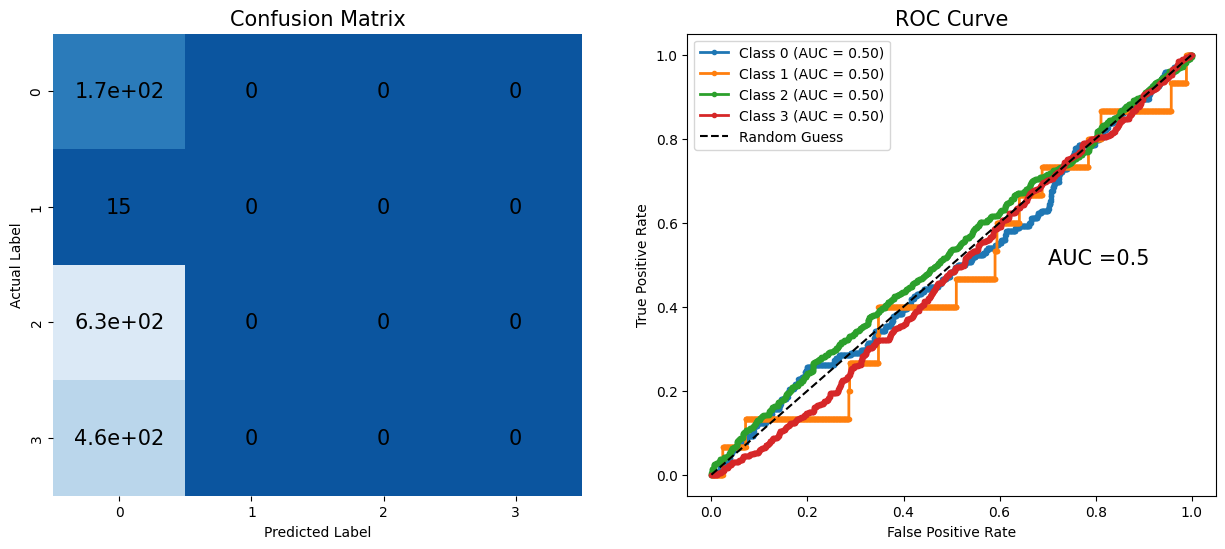


 ___________________________________________________________________________________________________
ExperimentName.FL_CDP_SF_CNN Model Classification Report
              precision    recall  f1-score   support

           0       0.13      1.00      0.24       172
           1       0.00      0.00      0.00        15
           2       0.00      0.00      0.00       634
           3       0.00      0.00      0.00       459

    accuracy                           0.13      1280
   macro avg       0.03      0.25      0.06      1280
weighted avg       0.02      0.13      0.03      1280

___________________________________________________________________________________________________

📊 Consolidated Metrics:
⏱️ Total Duration: 1317.10 sec
✅ Total Energy: 0.05260 kWh
🌍 Total CO₂ Emitted: 0.02262 kg
🧠 Peak CPU RAM: 0.00 GB
🖥️ Peak GPU VRAM: 0.97 GB

 ___________________________________________________________________________________________________


/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/emeka/PrivacyBench/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", le


🕒 Total Time: 17 min 7 sec


In [ ]:
project_root =  os.path.abspath("../..")

ray.shutdown()

ray.init(
    _temp_dir=str(RAY_LOG_DIR),
    runtime_env={
        "env_vars": {
            "PYTHONWARNINGS": "ignore::DeprecationWarning",  # More specific warning filter
            "OMP_NUM_THREADS": "1"  # Prevents thread oversubscription
        },
        "working_dir": project_root,
        'excludes': ['data', '.cache', '.docker', '.local', 'logs/model']
    },
    ignore_reinit_error=True
)

start_time = time.perf_counter()

run_simulation(
    server_app = server,
    client_app = client,
    num_supernodes = fed_config.get("num_clients"),
    backend_config=backend_setup
)


end_time = time.perf_counter()
duration = end_time - start_time
print(f"\n🕒 Total Time: {duration // 60:.0f} min {duration % 60:.0f} sec")

ray.shutdown()